In the last [post](https://miller-blog.com/inverse-problem-part-1/) I have written about inverse problems. A simplified toy example was presented, which showed you how to translate this problem into an optimization problem. Optimization problems can be solved by several algorithms, for example gradient descent or evolutionary algorithms.  
This article presents a more sophisticated inverse problem. We want to classify images of digits.  

<img src="https://raw.githubusercontent.com/arturmiller/MachineLearning/master/notebooks/images/classification_as_inversion.svg?sanitize=true" style="width: 50%;"/>  

In general inverse problems have causal factors from which observations arise. The test images are our observations. In our classification problem there are two kinds of forward models: 
- The first forward problem is the projection from the latent space $\mathbf{z}$ (I use the words "causal factors" and "latent space" interchangeable) to the image space $f(\mathbf{z})$. This is modeled as being a linear combination of example images $\mathbf{\phi}$ and the latent vector ($f(\mathbf{z})=\mathbf{\phi} \mathbf{z}$). The latent space has 10 dimensions. Each dimension is represented as an example image of each class. The predicted latent space $\mathbf{z^*}$ is found by optimzing the mean-squared-error of the deviation of the image $\mathbf{X}$ and $f(\mathbf{z})$.
$$L=\frac{1}{N}\sum_{n=1}^N{(X_n-f(z_n))^2}$$
$$\mathbf{z^*}=\underset{\mathbf{z}}{\operatorname{argmin}}(L)$$
- The second forward problem is the mapping from the latent space to the class prediction $y_{predict}$. Here it is simply the argmax operation. In other cases it could be a more complex model.
$$y_{predict}=\operatorname{argmax}(\mathbf{z^*})$$  
Defining the forward problems in this way, leads to a latent space, in which each dimension describes the weight of the corresponding class. It is not a probability distribution, since the values don't sum up to one.  
More complex causal factors, like translation and orientation could be modeled into the latent space as well. This isn't done here in this article to keep everything simple.  

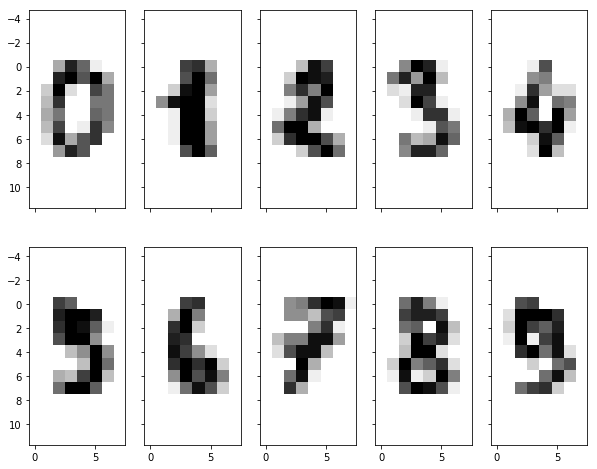

In [1]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pylab as plt

digits = datasets.load_digits(10)

f, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(10, 8))

for i in range(2):
    for j in range(5):
        ax[i, j].imshow(
            digits.images[i * 5 + j, :], cmap='gray_r')

These images are stacked into the $10\times64$ model matrix. Each example image is flattened and represented as a row in the model matrix.   
To show that this approach actually works, we want to classify the image of a zero, which is not contained in the model matrix.

cur_causal_factors: (10,)
model_params: (10, 64)
observation: (64,)


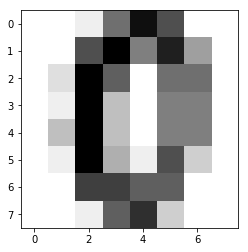

In [2]:
import numpy as np

cur_causal_factors = np.zeros(10)
print('cur_causal_factors: {}'.format(cur_causal_factors.shape))
model_params = digits.images[:10].reshape((10, -1))
print('model_params: {}'.format(model_params.shape))

observation = digits.images[10].reshape(-1)
print('observation: {}'.format(observation.shape))

plt.imshow(observation.reshape((8, 8)), cmap='gray_r')

Solving this inverse problem requires modeling the forward problem. In this example the forward problem is simply modeled as the matrix multiplication of the model matrix and flattened test image. The loss is defined as the mean squared error of the difference between the observation and the forward projected causal factors.
I'm using the [Einstein notation](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.einsum.html) here. The Einstein notation is implemented as a domain specific language, which abstracts away many vector, matrix and tensor operations. E.g. matrix multiplication, matrix transpose and dot product. A well written blog post about this topic can be found [here](https://rockt.github.io/2018/04/30/einsum).  
Solving the optimization problem with gradient descent leads to the best prediction of the causal factors. 

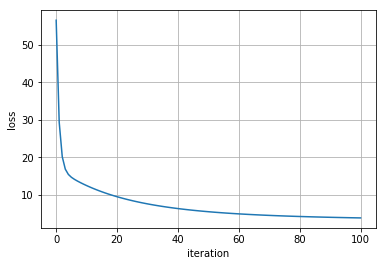

In [3]:
import tensorflow as tf

tf_cur_causal_factors = tf.Variable(cur_causal_factors, dtype=tf.float32)
tf_model_params = tf.constant(model_params, dtype=tf.float32)
tf_observation = tf.constant(observation, dtype=tf.float32)

def forward(tf_causal_factors):
    simulation = tf.einsum('i,ij->j', tf_causal_factors, tf_model_params)
    return simulation

tf_loss = tf.losses.mean_squared_error(tf_observation, forward(tf_cur_causal_factors))

alpha = 5e-4

optimizer = tf.train.GradientDescentOptimizer(alpha)
train = optimizer.minimize(tf_loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

losses = []
tmp_loss = sess.run(tf_loss)
losses.append(tmp_loss)

def eval_step(i=0):
    tmp_loss = sess.run(tf_loss)
    losses.append(tmp_loss)
    if i % 1 == 0:
        print('index: {} loss: {}'.format(i, tmp_loss), end='\r')

for i in range(100):
    sess.run(train)
    eval_step(i)

plt.plot(losses)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.figure()

In the next plot we see the result of the inverse problem. The class is predicted correctly as zero, because the zero dimension of the latent space has the highest value for the observed image.

predicted class: 0


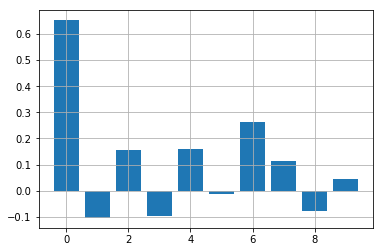

In [4]:
cur_causal_factors = sess.run(tf_cur_causal_factors)
prediction = np.argmax(cur_causal_factors)
print('predicted class: {}'.format(prediction))

plt.bar(range(10), cur_causal_factors)
plt.grid()

The next figure shows the results. At the left is the actual observed test image. The middle figure shows the projection of the resulting latent space into the image space. It can be seen, that the image is reproduced quite well. Since we have modeled the latent space (10 dimensions) to be smaller than the image space (64 dimensions) it is not possible to reproduce the observed image perfectly. The difference of both images is shown in the right figure. 

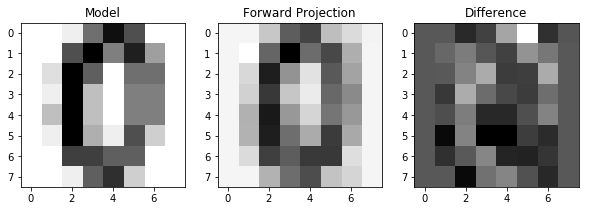

In [5]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].imshow(observation.reshape((8, 8)), cmap='gray_r')
ax[0].set_title('Model')
ax[1].imshow(sess.run(forward(tf_cur_causal_factors)).reshape((8, 8)), cmap='gray_r')
ax[1].set_title('Forward Projection')
ax[2].imshow(sess.run(forward(tf_cur_causal_factors)).reshape((8, 8)) - observation.reshape((8, 8)), cmap='gray_r')
ax[2].set_title('Difference')

We have seen, that classification problems can be translated into inverse problems and can be solved with gradient based optimization procedures. However, for classification there is not so much value in this approach, because the forward model has to be defined. If we are talking about classification, we are also talking about training the model with data. This is in fact possible. I show you in the next article how this is done. It is possible to use the same methods as we have seen already and to solve it as an optimization problem.